In [1]:
#conda install -c conda-forge ta-lib

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import warnings

from numpy.random import seed
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


# Suppress warnings, if you're sure they're inconsequential
warnings.filterwarnings('ignore')

# Setting random seeds for reproducibility
seed(10)
random.seed(10)
tf.random.set_seed(10)


In [3]:


# Low pass filter
def lowpassfilter(signal, layers = 3, wavelet="sym15"):

    coeff = pywt.wavedec(signal, wavelet, mode="constant")

    for i in range(0,layers):
        coeff[i].fill(0)
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="constant" )
    return reconstructed_signal

# Transform data into LSTM input format
def create_dataset(dataset, y_column=0, look_back=1):
	dataX, dataY = [], []
	for i in range(dataset.shape[0]-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, y_column])
	return np.array(dataX), np.array(dataY)
#The real Notebook start from here...


'''
path_datasets="/Users/danielpele/Library/CloudStorage/GoogleDrive-danpele@ase.ro/Other \
computers/Asus/G/PROIECTE/Understanding Digital Assets/Cod/Datasets/"
'''
path_datasets="D:/G/PROIECTE/Understanding Digital Assets/Cod/Datasets/"
df = pd.read_csv(path_datasets+"dataset_volume.csv",header=0, index_col=0)

df=df[['compound_sentiment','sentiment_intensity', 'final_sentiment_score','Total Interactions',
       'weighted_sentiment_neutral', 'weighted_sentiment_negative', 
       'weighted_sentiment_positive',
       'weighted_positive',
       'weighted_negative',
       'weighted_neutral',
       'weighted_compound',
       'Likes', 
       
       'Volume']]

df['Volume']=np.log(df['Volume'])

In [4]:


def add_lagged_columns(df, target_column,max_lag ):
    """
    Adds lagged values of all columns in the DataFrame up to a specified maximum lag.

    :param df: pandas DataFrame
    :param max_lag: integer, maximum number of periods to lag
    :return: DataFrame with original and lagged columns up to the max_lag
    """
    lagged_df = df.copy()
    for lag in range(1, max_lag + 1):
        for column in df.columns:
            #if column != target_column:
            lagged_df[f'{column}_lagged_{lag}'] = df[column].shift(lag)
    return lagged_df





from sklearn.feature_selection import mutual_info_regression
import pandas as pd

def select_relevant_features(df, target_column, n_features):
    """
    Selects the top n features based on mutual information score with the target column,
    including both lagged and non-lagged features.

    :param df: pandas DataFrame containing the features and target.
    :param target_column: the name of the target column.
    :param n_features: number of top features to select.
    :return: DataFrame with only the selected features and the target.
    """
    # Exclude the target column from the feature set
    features = df.drop(columns=[target_column])

    # Calculate mutual information scores
    mi_scores = mutual_info_regression(features, df[target_column])

    # Create a Series with feature names and their mutual information scores
    mi_scores = pd.Series(mi_scores, index=features.columns)

    # Select the top n features with the highest MI scores
    selected_features = mi_scores.nlargest(n_features).index

    # Return a DataFrame with only the selected features and the target
    return df[selected_features.to_list() + [target_column]]

# Example usage:
# Assuming you have a DataFrame 'df' and a target column 'target_col'
# selected_df = select_relevant_features(df, 'target_col', 5)


#=============== Final Function =============================

def Final_Data_Preparation(Data,target):


    data = add_lagged_columns(Data,  target, max_lag=5)
    data=data.dropna()
    selected_df = select_relevant_features(data, target, 20)

    return selected_df
  

In [5]:
target='Volume'
data = Final_Data_Preparation(df,target)




In [6]:
data.head()

,Volume_lagged_1,Volume_lagged_2,Volume_lagged_4,Volume_lagged_3,Volume_lagged_5,weighted_sentiment_negative,weighted_sentiment_negative_lagged_4,Total Interactions_lagged_2,Total Interactions,weighted_sentiment_negative_lagged_3,...,weighted_sentiment_negative_lagged_2,Total Interactions_lagged_1,weighted_sentiment_positive,Total Interactions_lagged_5,Total Interactions_lagged_3,Total Interactions_lagged_4,weighted_sentiment_negative_lagged_5,weighted_sentiment_neutral_lagged_5,weighted_sentiment_positive_lagged_1,Volume
date,,,,,,,,,,,,,,,,,,,,,
2015-01-11,16.541027,16.745028,17.029044,16.810367,16.961631,0.000000,278.770315,2226.0,0,0.000000,...,66.570049,0.0,0.000000,605.0,0.0,319.0,560.177134,38.045971,0.000000,16.716976
2015-01-12,16.716976,16.541027,16.810367,16.745028,17.029044,232.105914,0.000000,0.0,12078,66.570049,...,0.000000,0.0,635.726709,319.0,2226.0,0.0,278.770315,35.805121,0.000000,16.753630
2015-01-13,16.753630,16.716976,16.745028,16.541027,16.810367,6.801459,66.570049,0.0,380,0.000000,...,0.000000,12078.0,51.163962,0.0,0.0,2226.0,0.000000,0.000000,635.726709,18.103829
2015-01-14,18.103829,16.753630,16.541027,16.716976,16.745028,39.564914,0.000000,12078.0,1067,0.000000,...,232.105914,380.0,84.947572,2226.0,0.0,0.0,66.570049,2092.644385,51.163962,18.396785
2015-01-15,18.396785,18.103829,16.716976,16.753630,16.541027,0.000000,0.000000,380.0,0,232.105914,...,6.801459,1067.0,0.000000,0.0,12078.0,0.0,0.000000,0.000000,84.947572,18.219464


In [7]:
# 

In [8]:
%%time
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from math import sqrt
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'target' is your target column
target = 'Volume'
X = data.drop([target], axis=1)
y = data[target]

# Scale variables
scaler_X = PowerTransformer()
X_scaled = scaler_X.fit_transform(X)

scaler_y = PowerTransformer()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten() # Reshape y and flatten the transformed array

# Define sizes for validation and test sets
val_size = int(len(X) * 0.1)
test_size = int(len(X) * 0.2)

# Sequential Split into Training, Validation, and Test Sets
X_train, X_val_test = X_scaled[:-val_size - test_size], X_scaled[-val_size - test_size:]
y_train, y_val_test = y_scaled[:-val_size - test_size], y_scaled[-val_size - test_size:]

X_val, X_test = X_val_test[:val_size], X_val_test[val_size:]
y_val, y_test = y_val_test[:val_size], y_val_test[val_size:]


CPU times: total: 203 ms
Wall time: 260 ms


# Baseline: Linear Regression

Train RMSE (Scaled Data): 0.1048820573704859
Validation RMSE (Scaled Data): 0.1423271662364698
Test RMSE (Scaled Data): 0.1934646019455632
Train R2: 0.989
Validation R2: 0.685
Test R2: 0.630


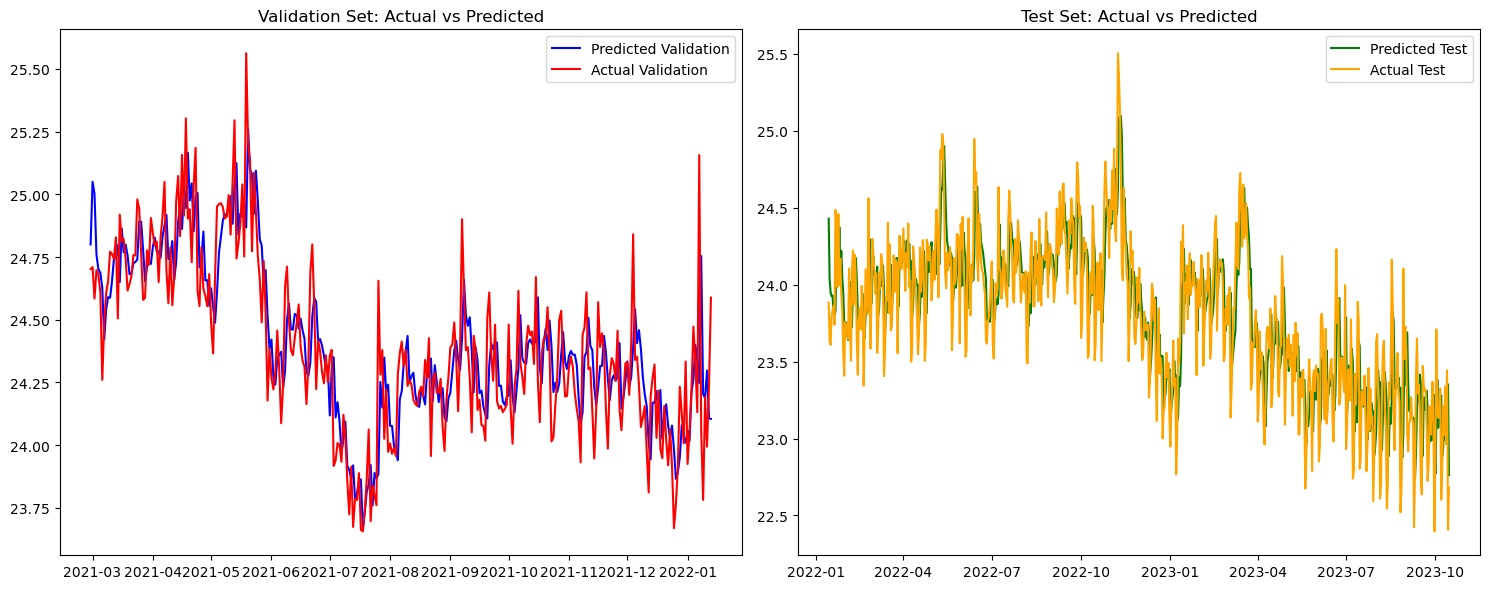

CPU times: total: 188 ms
Wall time: 270 ms


In [9]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming the training, validation, and test sets (X_train, y_train, X_val, y_val, X_test, y_test) are already defined
# And assuming scaler_X and scaler_y are already fitted to the training data

# Train the Linear Regression model
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

# Predict on the Validation Set
predictions_val_scaled = model_reg.predict(X_val)
predictions_val = scaler_y.inverse_transform(predictions_val_scaled.reshape(-1, 1)).flatten()
y_val_original = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()

# Predict on the Train Set
predictions_test_scaled = model_reg.predict(X_test)
predictions_test = scaler_y.inverse_transform(predictions_test_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate RMSE for the Validation Set
rmse_val = sqrt(mean_squared_error(y_val_original, predictions_val))

# Calculate RMSE for the Test Set
rmse_test = sqrt(mean_squared_error(y_test_original, predictions_test))

# Predict on Validation and Test Sets
yhat_train= model_reg.predict(X_train)
yhat_val = model_reg.predict(X_val)
yhat_test = model_reg.predict(X_test)

# Compute RMSE on the scaled data
rmse_train = sqrt(mean_squared_error(y_train, yhat_train))
rmse_val = sqrt(mean_squared_error(y_val, yhat_val))
rmse_test = sqrt(mean_squared_error(y_test, yhat_test))

print(f'Train RMSE (Scaled Data): {rmse_train}')
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')

# R2 calculation for the Train Set
r2_train = model_reg.score(X_train, y_train)

# R2 calculation for the Test Set
r2_test = model_reg.score(X_test, y_test)

# R2 calculation for the Validation Set
r2_val = model_reg.score(X_val, y_val)




# Output the R2 values
print(f'Train R2: {r2_train:.3f}')
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')

# Plotting for the Validation Set
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), predictions_val, label='Predicted Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_original, label='Actual Validation', color='red')
plt.title('Validation Set: Actual vs Predicted')
plt.legend()


# Plotting for the Test Set
plt.subplot(1, 2, 2)

plt.plot(pd.to_datetime(data.index[-test_size:]), predictions_test, label='Predicted Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_original, label='Actual Test', color='orange')
plt.title('Test Set: Actual vs Predicted')
plt.legend()


plt.tight_layout()
plt.show()

# RFR

Train R2: 0.998
Validation R2: 0.514
Test R2: 0.451
Train RMSE (Scaled Data): 0.0401914212541255
Validation RMSE (Scaled Data): 0.17667633988468187
Test RMSE (Scaled Data): 0.23548502727561113


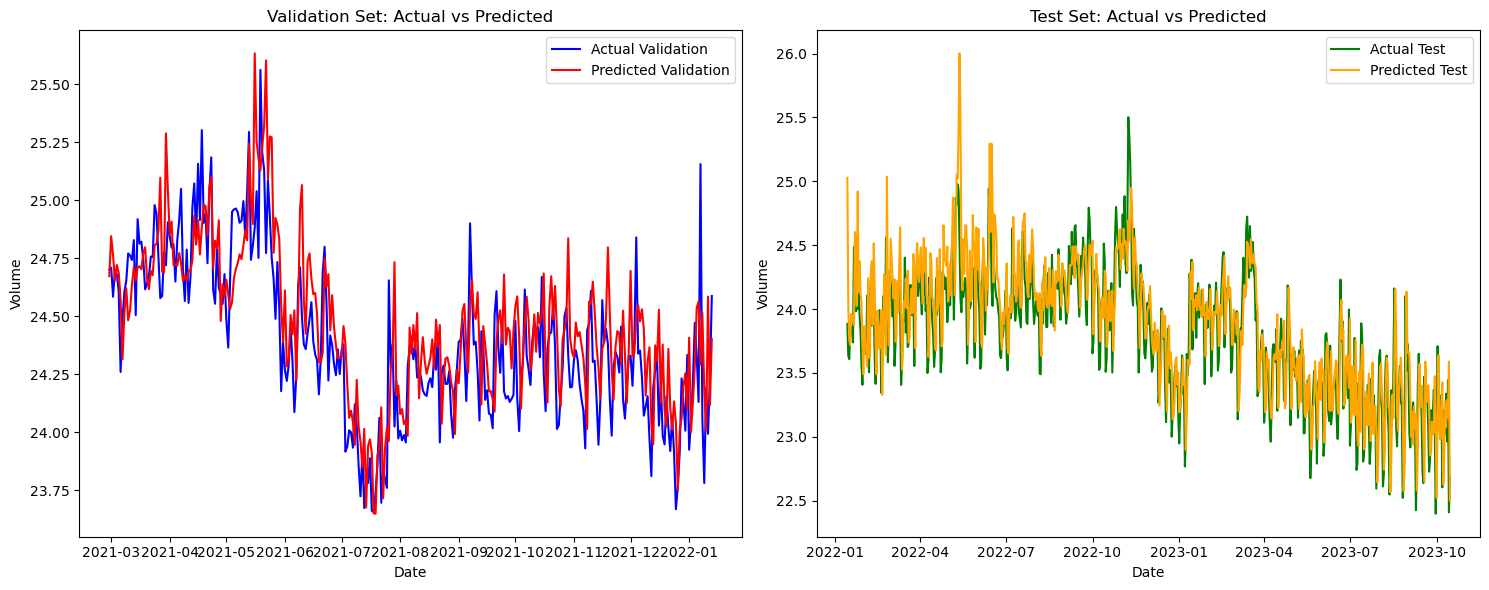

In [11]:

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

 

r2_val = rf.score(X_val, y_val)  # Calculate R2 for Validation Set

r2_test = rf.score(X_test, y_test)  # Calculate R2 for Test Set

r2_train = rf.score(X_train, y_train)  # Calculate R2 for Test Set

# Output the R2 values
print(f'Train R2: {r2_train:.3f}')
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')

# Predict on Validation and Test Sets
yhat_train= rf.predict(X_train)
yhat_val = rf.predict(X_val)
yhat_test = rf.predict(X_test)

# Compute RMSE on the scaled data
rmse_train = sqrt(mean_squared_error(y_train, yhat_train))
rmse_val = sqrt(mean_squared_error(y_val, yhat_val))
rmse_test = sqrt(mean_squared_error(y_test, yhat_test))

print(f'Train RMSE (Scaled Data): {rmse_train}')
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')

# Predict and Evaluate on Validation Set
predictions_val = rf.predict(X_val)


# Predict and Evaluate on Test Set
predictions_test = rf.predict(X_test)
# Invert scaling
predictions_val_inverted = scaler_y.inverse_transform(predictions_val.reshape(-1, 1)).flatten() # Reshape before inverse transform
predictions_test_inverted = scaler_y.inverse_transform(predictions_test.reshape(-1, 1)).flatten() # Reshape before inverse transform
y_val_inverted = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten() # Reshape before inverse transform
y_test_inverted = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten() # Reshape before inverse transform

# Plotting
# For Validation Set
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_inverted, label='Actual Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), predictions_val_inverted, label='Predicted Validation', color='red')
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Date')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.ylabel('Volume')
plt.legend()

# For Test Set
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_inverted, label='Actual Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), predictions_test_inverted, label='Predicted Test', color='orange')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()




# Stacked LSTM

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           5,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,705 (233.23 KB)

 Trainable params: 19,901 (77.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,804 (155.49 KB)

Train RMSE (Scaled Data): 0.08058848640713302
Validation RMSE (Scaled Data): 0.23226306323202303
Test RMSE (Scaled Data): 0.24533729428040318
Train R2: 0.993
Validation R2: 0.161
Test R2: 0.404


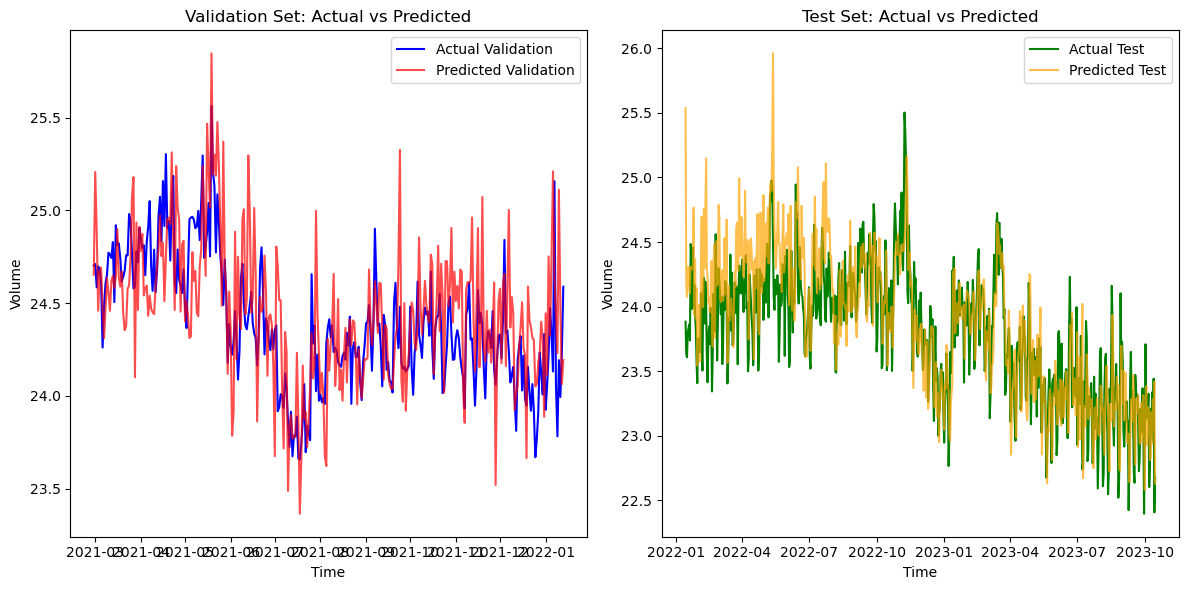

Validation RMSE: 0.232
Test RMSE: 0.245


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
import tensorflow as tf
from sklearn.metrics import r2_score


# Reshape for LSTM: [samples, time steps, features]
n_features = X.shape[1]
X_train = X_train.reshape((X_train.shape[0], 1, n_features))
X_val = X_val.reshape((X_val.shape[0], 1, n_features))
X_test = X_test.reshape((X_test.shape[0], 1, n_features))

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, n_features)))
model_lstm.add(LSTM(20, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Fit the model
model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0)

model_lstm.summary()

# Predict on Validation and Test Sets
yhat_train= model_lstm.predict(X_train, verbose=0)
yhat_val = model_lstm.predict(X_val, verbose=0)
yhat_test = model_lstm.predict(X_test, verbose=0)

# Compute RMSE on the scaled data
rmse_train = sqrt(mean_squared_error(y_train, yhat_train))
rmse_val = sqrt(mean_squared_error(y_val, yhat_val))
rmse_test = sqrt(mean_squared_error(y_test, yhat_test))

print(f'Train RMSE (Scaled Data): {rmse_train}')
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')

# Calculate R2 score for Validation, Train and Test Sets
r2_val = r2_score(y_val, yhat_val)
r2_test = r2_score(y_test, yhat_test)
r2_train = r2_score(y_train, yhat_train)
# Output the R2 values
print(f'Train R2: {r2_train:.3f}')
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')

# Invert scaling for predictions and actual values using the target transformer
yhat_val_inverted = scaler_y.inverse_transform(yhat_val)
yhat_test_inverted = scaler_y.inverse_transform(yhat_test)


# Reshape before inverse transform
y_val_inverted = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten() # Reshape before inverse transform
y_test_inverted = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten() # Reshape before inverse transform
# Plot Predicted vs Actual Values after inverting scaling for Validation Set
plt.figure(figsize=(12, 6))

# Plot for Validation Set
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_inverted, label='Actual Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), yhat_val_inverted, label='Predicted Validation', color='red', alpha=0.7)
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

# Plot for Test Set
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_inverted, label='Actual Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), yhat_test_inverted, label='Predicted Test', color='orange', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

plt.tight_layout()
plt.show()

print(f'Validation RMSE: {rmse_val:.3f}')
print(f'Test RMSE: {rmse_test:.3f}')


# CNN

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 19, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,356 (579.52 KB)

 Trainable params: 74,177 (289.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 74,179 (289.77 KB)

Train RMSE (Scaled Data): 0.08286664858541384
Validation RMSE (Scaled Data): 0.2178613800653399
Test RMSE (Scaled Data): 0.2577709879045127
Train R2: 0.993
Validation R2: 0.261
Test R2: 0.342


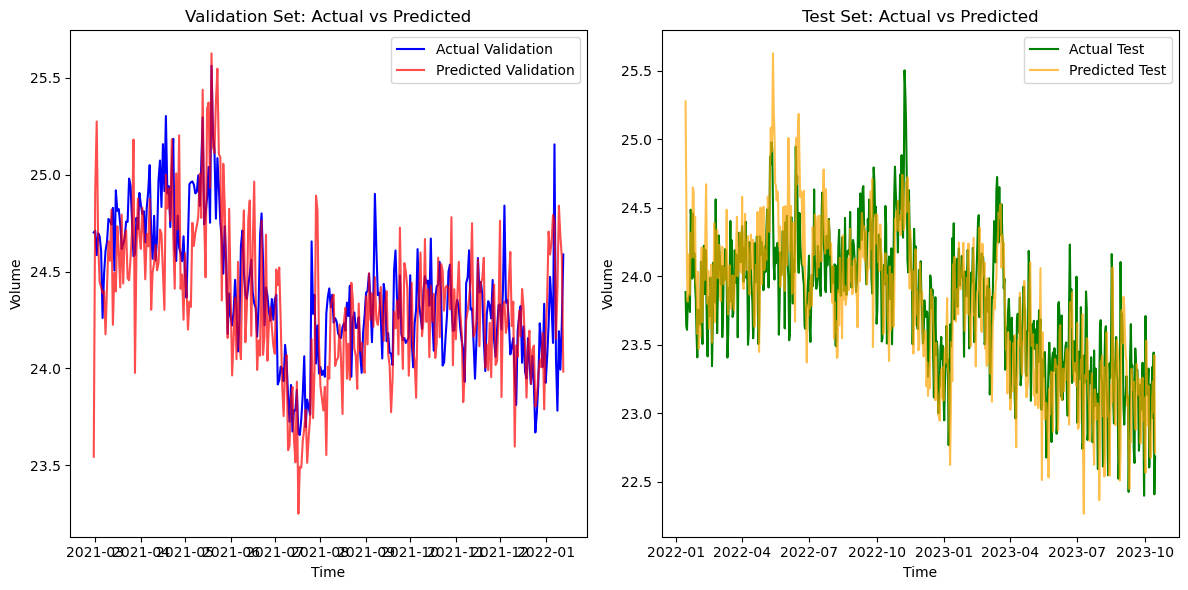

CPU times: total: 7.3 s
Wall time: 49.6 s


In [13]:

%%time
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from numpy import array, sqrt
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your DataFrame and 'target' is the name of your target column

# Apply PowerTransformer
scaler = PowerTransformer()
data_scaled_array = scaler.fit_transform(data)

# Splitting features and target
X = data_scaled_array[:, :-1]
y = data_scaled_array[:, -1]

# Reshape for CNN: [samples, time steps, features]
n_steps = 7  # Choose a number of time steps
n_features = X.shape[1]
X = X.reshape((X.shape[0], n_features, 1))

# Define sizes for validation and test sets
val_size = int(len(X) * 0.1)
test_size = int(len(X) * 0.2)

# Sequential Split into Training, Validation, and Test Sets
X_train, X_val_test = X_scaled[:-val_size - test_size], X_scaled[-val_size - test_size:]
y_train, y_val_test = y_scaled[:-val_size - test_size], y_scaled[-val_size - test_size:]

X_val, X_test = X_val_test[:val_size], X_val_test[val_size:]
y_val, y_test = y_val_test[:val_size], y_val_test[val_size:]

# Define the CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_features, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='RMSprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit the model
model_cnn.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

# Model summary
model_cnn.summary()


# Predict on Validation and Test Sets
yhat_train= model_cnn.predict(X_train, verbose=0)
yhat_val = model_cnn.predict(X_val, verbose=0)
yhat_test = model_cnn.predict(X_test, verbose=0)

# Compute RMSE on the scaled data
rmse_train = sqrt(mean_squared_error(y_train, yhat_train))
rmse_val = sqrt(mean_squared_error(y_val, yhat_val))
rmse_test = sqrt(mean_squared_error(y_test, yhat_test))
print(f'Train RMSE (Scaled Data): {rmse_train}')
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')


# Calculate R2 score for Validation, Train and Test Sets
r2_val = r2_score(y_val, yhat_val)
r2_test = r2_score(y_test, yhat_test)
r2_train = r2_score(y_train, yhat_train)
# Output the R2 values
print(f'Train R2: {r2_train:.3f}')
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')

# Invert scaling for predictions and actual values using the target transformer
yhat_val_inverted = scaler_y.inverse_transform(yhat_val)
yhat_test_inverted = scaler_y.inverse_transform(yhat_test)


# Reshape before inverse transform
y_val_inverted = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten() # Reshape before inverse transform
y_test_inverted = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten() # Reshape before inverse transform
# Plot Predicted vs Actual Values after inverting scaling for Validation Set
plt.figure(figsize=(12, 6))

# Plot for Validation Set
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_inverted, label='Actual Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), yhat_val_inverted, label='Predicted Validation', color='red', alpha=0.7)
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

# Plot for Test Set
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_inverted, label='Actual Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), yhat_test_inverted, label='Predicted Test', color='orange', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

plt.tight_layout()
plt.show()






# LSTM CNN (LRCN)

(3193, 7, 20) (3193,)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 6, 32)         │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 3, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 40)                  │          21,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,821 (272.74 KB)

 Trainable params: 23,273 (90.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,548 (181.83 KB)

Train RMSE (Scaled Data): 0.06620760773318828
Validation RMSE (Scaled Data): 0.25009714149338547
Test RMSE (Scaled Data): 0.27662878417844333
Train R2: 0.996
Validation R2: 0.042
Test R2: 0.245


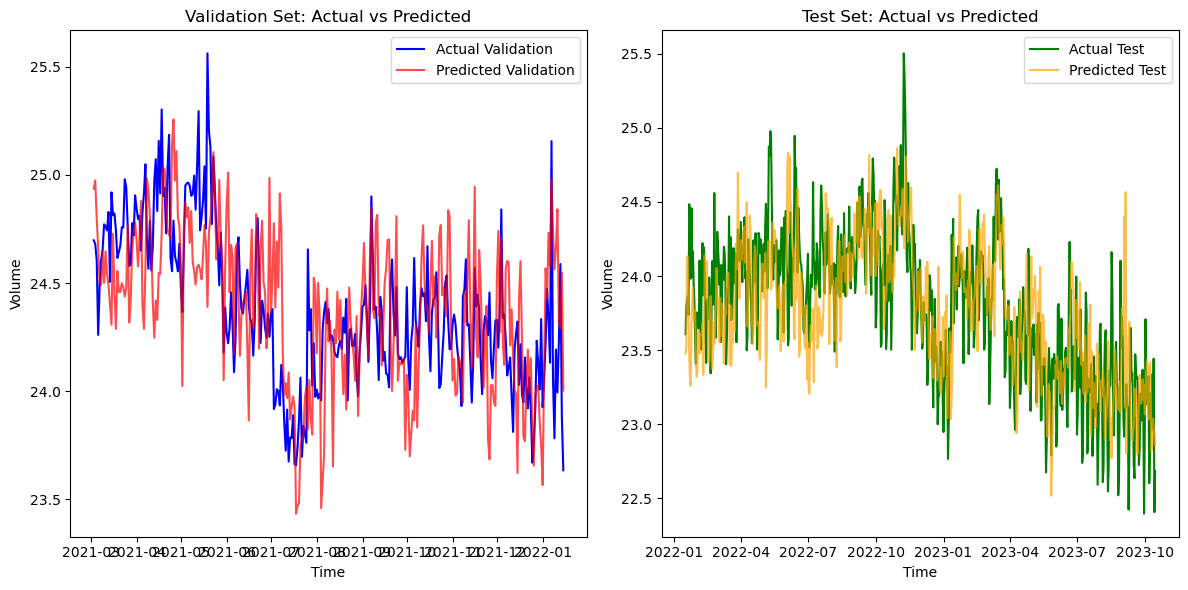

CPU times: total: 8.56 s
Wall time: 52.3 s


In [14]:

%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, TimeDistributed
from math import sqrt
import tensorflow as tf

# Assuming 'data' is a DataFrame or a NumPy array containing the time series data

# If 'data' is a DataFrame, extract its values
if isinstance(data, pd.DataFrame):
    data_values = data.values
else:
    data_values = data  # Assuming data is already a NumPy array

# Apply PowerTransformer
scaler = PowerTransformer()
data_scaled = scaler.fit_transform(data_values)

# Split the data into features and target
X, y = data_scaled[:, :-1], data_scaled[:, -1]
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:(i + n_steps)])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys)

# Define the number of timesteps per sequence
n_steps = 7

# Create sequences
X_sequence, y_sequence = create_sequences(X, y, n_steps)

# Check the shapes to ensure alignment
print(X_sequence.shape, y_sequence.shape)

# Define sizes for validation and test sets (ensure these are divisible by the number of sequences)
val_size = int(len(X_sequence) * 0.1)
test_size = int(len(X_sequence) * 0.2)

# Sequential Split into Training, Validation, and Test Sets
X_train, X_val_test = X_sequence[:-val_size - test_size], X_sequence[-val_size - test_size:]
y_train, y_val_test = y_sequence[:-val_size - test_size], y_sequence[-val_size - test_size:]

X_val, X_test = X_val_test[:val_size], X_val_test[val_size:]
y_val, y_test = y_val_test[:val_size], y_val_test[val_size:]

# Reshape X for CNN-LSTM model: [samples, subsequences, timesteps, features]
n_features = X.shape[1] 
n_seq = 1 # Number of subsequences

X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_val = X_val.reshape((X_val.shape[0], n_seq, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

# Continue with model definition, training, and evaluation...




# Define the model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(40, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit the model
model_cnn_lstm.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

# Model summary
model_cnn_lstm.summary()



# Predict on Validation and Test Sets
yhat_train= model_cnn_lstm.predict(X_train, verbose=0)
yhat_val = model_cnn_lstm.predict(X_val, verbose=0)
yhat_test = model_cnn_lstm.predict(X_test, verbose=0)

# Compute RMSE on the scaled data
rmse_train = sqrt(mean_squared_error(y_train, yhat_train))
rmse_val = sqrt(mean_squared_error(y_val, yhat_val))
rmse_test = sqrt(mean_squared_error(y_test, yhat_test))

print(f'Train RMSE (Scaled Data): {rmse_train}')
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')
# Calculate R2 score for Validation, Train and Test Sets
r2_val = r2_score(y_val, yhat_val)
r2_test = r2_score(y_test, yhat_test)
r2_train = r2_score(y_train, yhat_train)
# Output the R2 values
print(f'Train R2: {r2_train:.3f}')
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')

# Invert scaling for predictions and actual values using the target transformer
yhat_val_inverted = scaler_y.inverse_transform(yhat_val)
yhat_test_inverted = scaler_y.inverse_transform(yhat_test)


# Reshape before inverse transform
y_val_inverted = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten() # Reshape before inverse transform
y_test_inverted = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten() # Reshape before inverse transform
# Plot Predicted vs Actual Values after inverting scaling for Validation Set
plt.figure(figsize=(12, 6))

# Plot for Validation Set
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_inverted, label='Actual Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), yhat_val_inverted, label='Predicted Validation', color='red', alpha=0.7)
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

# Plot for Test Set
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_inverted, label='Actual Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), yhat_test_inverted, label='Predicted Test', color='orange', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

plt.tight_layout()
plt.show()





# Bidirectional LSTM (BiLSTM)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 7, 64)               │          13,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,036 (203.27 KB)

 Trainable params: 26,017 (101.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,019 (101.64 KB)

Train RMSE (Scaled Data): 0.093340266510662
Validation RMSE (Scaled Data): 0.17008035864427798
Test RMSE (Scaled Data): 0.19301202431054212
Train R2: 0.991
Validation R2: 0.557
Test R2: 0.632


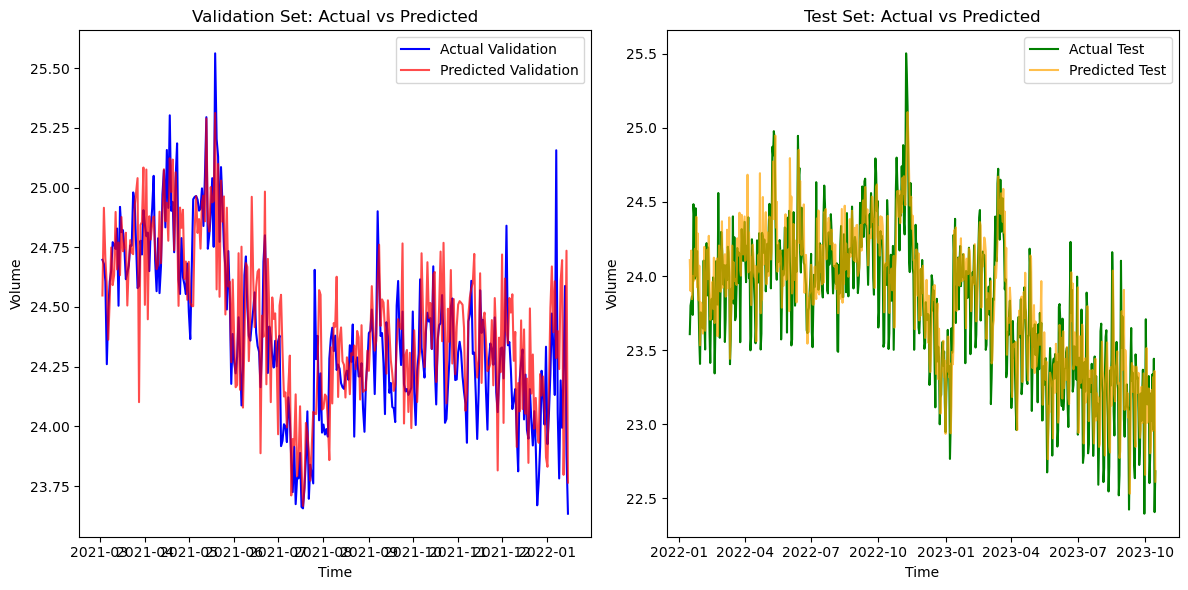

CPU times: total: 21.1 s
Wall time: 2min 6s


In [15]:
%%time
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to split sequences
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Assuming 'data' is a DataFrame
# Replace this with the actual data loading step
# data = pd.read_csv('your_data.csv') or similar

scaler = PowerTransformer()
data_array = scaler.fit_transform(data)

y_scaler = PowerTransformer()
y_prime = data_array[:, -1].reshape(-1, 1)
y_prime = y_scaler.fit_transform(y_prime)

n_steps = 7
X_sequence, y_sequence = split_sequences(data_array, n_steps)

# Define sizes for validation and test sets (ensure these are divisible by the number of sequences)
val_size = int(len(X_sequence) * 0.1)
test_size = int(len(X_sequence) * 0.2)

# Sequential Split into Training, Validation, and Test Sets
X_train, X_val_test = X_sequence[:-val_size - test_size], X_sequence[-val_size - test_size:]
y_train, y_val_test = y_sequence[:-val_size - test_size], y_sequence[-val_size - test_size:]

X_val, X_test = X_val_test[:val_size], X_val_test[val_size:]
y_val, y_test = y_val_test[:val_size], y_val_test[val_size:]
n_features = X_sequence.shape[2]




# model definition
model_bi_lstm = Sequential()
model_bi_lstm.add(Bidirectional(LSTM(32, activation='sigmoid', return_sequences=True), input_shape=(n_steps, n_features)))
model_bi_lstm.add(LSTM(32, activation='sigmoid'))
model_bi_lstm.add(Dense(1))
model_bi_lstm.compile(optimizer='RMSprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])




history =model_bi_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32, verbose=0)

model_bi_lstm.summary()

# Predict on Validation and Test Sets
yhat_train= model_bi_lstm.predict(X_train, verbose=0)
yhat_val = model_bi_lstm.predict(X_val, verbose=0)
yhat_test = model_bi_lstm.predict(X_test, verbose=0)

# Compute RMSE on the scaled data
rmse_train = sqrt(mean_squared_error(y_train, yhat_train))
rmse_val = sqrt(mean_squared_error(y_val, yhat_val))
rmse_test = sqrt(mean_squared_error(y_test, yhat_test))

print(f'Train RMSE (Scaled Data): {rmse_train}')
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')

# Calculate R2 score for Validation, Train and Test Sets
r2_val = r2_score(y_val, yhat_val)
r2_test = r2_score(y_test, yhat_test)
r2_train = r2_score(y_train, yhat_train)
# Output the R2 values
print(f'Train R2: {r2_train:.3f}')
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')
# Invert scaling for predictions and actual values using the target transformer
yhat_val_inverted = scaler_y.inverse_transform(yhat_val)
yhat_test_inverted = scaler_y.inverse_transform(yhat_test)


# Reshape before inverse transform
y_val_inverted = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten() # Reshape before inverse transform
y_test_inverted = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten() # Reshape before inverse transform
# Plot Predicted vs Actual Values after inverting scaling for Validation Set
plt.figure(figsize=(12, 6))

# Plot for Validation Set
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_inverted, label='Actual Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), yhat_val_inverted, label='Predicted Validation', color='red', alpha=0.7)
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

# Plot for Test Set
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_inverted, label='Actual Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), yhat_test_inverted, label='Predicted Test', color='orange', alpha=0.7)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

plt.tight_layout()
plt.show()



# Gated Recurrent Unit (GRU)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 7, 64)               │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,620 (154.77 KB)

 Trainable params: 19,809 (77.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,811 (77.39 KB)

Train RMSE (Scaled Data): 0.08445709925417988
Validation RMSE (Scaled Data): 0.18396348836772475
Test RMSE (Scaled Data): 0.19589911252312894
Train R2: 0.993
Validation R2: 0.482
Test R2: 0.621


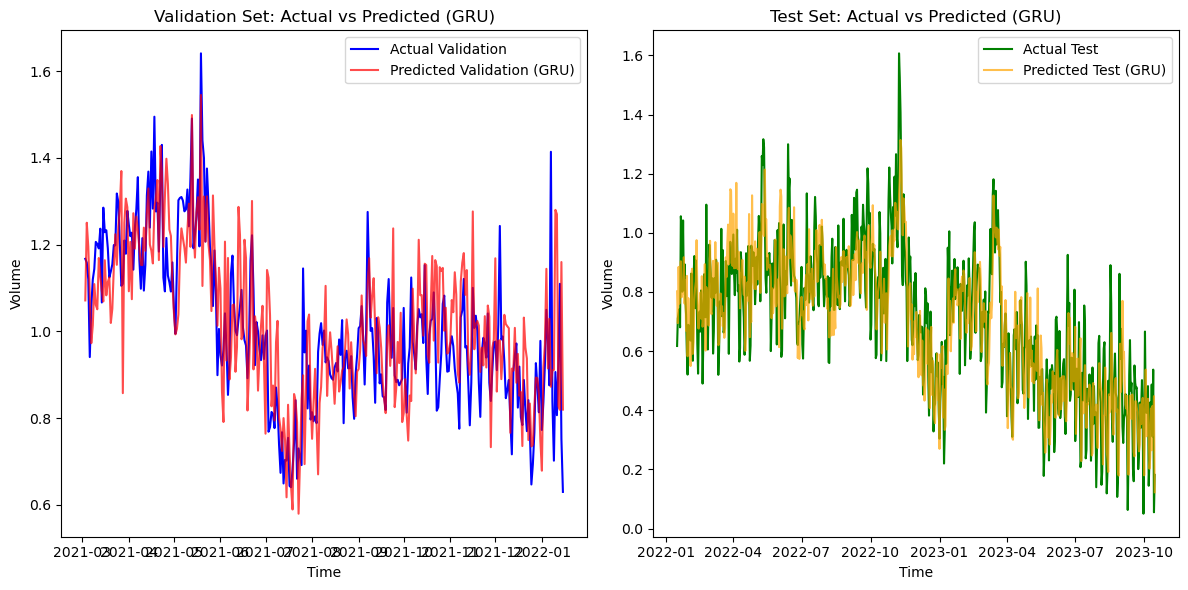

In [16]:
from keras.layers import GRU


# Model definition with GRU
model_gru = Sequential()
model_gru.add(Bidirectional(GRU(32, activation='sigmoid', return_sequences=True), input_shape=(n_steps, n_features)))
model_gru.add(GRU(32, activation='sigmoid'))
model_gru.add(Dense(1))
model_gru.compile(optimizer='RMSprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Fit the GRU model
history = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32, verbose=0)

model_gru.summary()

# Predict on Validation and Test Sets
yhat_train= model_gru.predict(X_train, verbose=0)
yhat_val_gru = model_gru.predict(X_val, verbose=0)
yhat_test_gru = model_gru.predict(X_test, verbose=0)

# Compute RMSE on the scaled data
rmse_train = sqrt(mean_squared_error(y_train, yhat_train))
rmse_val = sqrt(mean_squared_error(y_val, yhat_val_gru))
rmse_test = sqrt(mean_squared_error(y_test, yhat_test_gru))

print(f'Train RMSE (Scaled Data): {rmse_train}')
print(f'Validation RMSE (Scaled Data): {rmse_val}')
print(f'Test RMSE (Scaled Data): {rmse_test}')

# Calculate R2 score for Validation, Train and Test Sets
r2_val = r2_score(y_val, yhat_val_gru)
r2_test = r2_score(y_test, yhat_test_gru)
r2_train = r2_score(y_train, yhat_train)
# Output the R2 values
print(f'Train R2: {r2_train:.3f}')
print(f'Validation R2: {r2_val:.3f}')
print(f'Test R2: {r2_test:.3f}')

# Invert scaling for GRU predictions and actual values
yhat_val_inverted_gru = y_scaler.inverse_transform(yhat_val_gru)
yhat_test_inverted_gru = y_scaler.inverse_transform(yhat_test_gru)

# Reshape before inverse transform for actual values
y_val_inverted = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_inverted = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot Predicted vs Actual Values after inverting scaling for Validation Set using GRU model
plt.figure(figsize=(12, 6))

# Plot for Validation Set - GRU Model
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), y_val_inverted, label='Actual Validation', color='blue')
plt.plot(pd.to_datetime(data.index[-val_size - test_size:-test_size]), yhat_val_inverted_gru, label='Predicted Validation (GRU)', color='red', alpha=0.7)
plt.title('Validation Set: Actual vs Predicted (GRU)')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

# Plot for Test Set - GRU Model
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(data.index[-test_size:]), y_test_inverted, label='Actual Test', color='green')
plt.plot(pd.to_datetime(data.index[-test_size:]), yhat_test_inverted_gru, label='Predicted Test (GRU)', color='orange', alpha=0.7)
plt.title('Test Set: Actual vs Predicted (GRU)')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()

plt.tight_layout()
plt.show()

